In [86]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
df = spark.read.csv("./Data/data.csv", header=True, inferSchema=True,encoding="ISO-8859-1")
df.show(5)

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per c

In [87]:
print(df.count())
print(len(df.columns))
print(spark.sparkContext.uiWebUrl)
print(spark.version) 

180519
53
http://DESKTOP-NGQMNHG:4040
4.0.1


In [88]:
from pyspark.sql.functions import count, when, col

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Ca

In [89]:
df.dtypes
df_new = df.drop("Category Id","Market","Customer Country", "Customer City","Customer Email", "Customer Fname","Order Item Total", "Customer Lname","Customer Password", "Customer Id","Customer State","Order Item Discount","Customer Street", "Customer Zipcode","Department Id","Order Zipcode", "Department Name","Order Item Discount Rate","Order Customer Id", "Order Id", "Order Item Id","Order Item Cardprod Id","Order Item Product Price","Product Card Id", "Product Category Id","Product Image", "Product Description", "Product Price", "Sales per customer", "Order Profit Per Order","Order Item Profit Ratio","Delivery Status","Product Status")


In [90]:
print(df.count())
print(len(df.columns))
print(df_new.count())
print(len(df_new.columns))

180519
53
180519
20


In [91]:
df_new = df_new.toDF(*(c.replace(' ', '_') for c in df_new.columns))
df_new = df_new.toDF(*[c.lower() for c in df_new.columns])
df_new = df_new.withColumnRenamed("days_for_shipping_(real)", "days_for_shipping")
df_new = df_new.withColumnRenamed("days_for_shipment_(scheduled)", "scheduled_days_for_shipping")
df_new = df_new.withColumnRenamed("order_date_(dateorders)", "order_date")
df_new = df_new.withColumnRenamed("shipping_date_(dateorders)", "shipping_date")

df_new.show(3)

+--------+-----------------+---------------------------+-----------------+------------------+--------------+----------------+-----------+------------+----------+-------------+---------------+-------------------+------+--------------+---------------+------------+------------+---------------+--------------+
|    type|days_for_shipping|scheduled_days_for_shipping|benefit_per_order|late_delivery_risk| category_name|customer_segment|   latitude|   longitude|order_city|order_country|     order_date|order_item_quantity| sales|  order_region|    order_state|order_status|product_name|  shipping_date| shipping_mode|
+--------+-----------------+---------------------------+-----------------+------------------+--------------+----------------+-----------+------------+----------+-------------+---------------+-------------------+------+--------------+---------------+------------+------------+---------------+--------------+
|   DEBIT|                3|                          4|            91.25|     

In [92]:
from pyspark.sql.functions import col, radians, sin, cos, sqrt, atan2, lit
from pyspark.sql.types import DoubleType

print("Loading geocoded coordinates from CSV...")
print("="*80)

if 'dest_latitude' in df_new.columns:
    df_new = df_new.drop('dest_latitude', 'dest_longitude')
if 'distance_km' in df_new.columns:
    df_new = df_new.drop('distance_km')

geocoded_csv_path = "./Data/geocoded_locations.csv"
geocoded_spark_df = spark.read.csv(geocoded_csv_path, header=True, inferSchema=True, encoding='utf-8')
print(f"✓ Loaded geocoded locations as Spark DataFrame")

print("\nMerging geocoded coordinates...")
df_new = df_new.join(
    geocoded_spark_df,
    on=['order_city', 'order_state', 'order_region', 'order_country'],
    how='left'
)
print("✓ Merge completed")

print("\nCalculating distances using Haversine formula...")

R = 6371 

df_new = df_new.withColumn(
    'distance_km',
    (
        lit(2) * R * 
        atan2(
            sqrt(
                sin(radians(col('dest_latitude') - col('latitude')) / lit(2)) ** 2 +
                cos(radians(col('latitude'))) * 
                cos(radians(col('dest_latitude'))) * 
                sin(radians(col('dest_longitude') - col('longitude')) / lit(2)) ** 2
            ),
            sqrt(
                lit(1) - (
                    sin(radians(col('dest_latitude') - col('latitude')) / lit(2)) ** 2 +
                    cos(radians(col('latitude'))) * 
                    cos(radians(col('dest_latitude'))) * 
                    sin(radians(col('dest_longitude') - col('longitude')) / lit(2)) ** 2
                )
            )
        )
    ).cast(DoubleType())
)

print("✓ Distance calculation completed")

print("\n" + "="*80)
print("✓ DISTANCE CALCULATION COMPLETED!")
print("="*80)

total_rows = df_new.count()
rows_with_distance = df_new.filter(col('distance_km').isNotNull()).count()

print(f"\nRows with calculated distance: {rows_with_distance:,} / {total_rows:,}")
print(f"Success rate: {(rows_with_distance / total_rows * 100):.2f}%")

if rows_with_distance > 0:
    print("\nDistance Statistics:")
    print("-"*80)
    
    stats = df_new.select('distance_km').summary('count', 'mean', 'stddev', 'min', 'max')
    stats_data = stats.collect()
    
    for row in stats_data:
        metric = row['summary']
        value = row['distance_km']
        if value and metric != 'count':
            print(f"  {metric.capitalize()}: {float(value):.2f} km")
        elif value:
            print(f"  {metric.capitalize()}: {value}")

print("\n✓ DataFrame remains as Spark DataFrame")
print(f"✓ New columns added: dest_latitude, dest_longitude, distance_km")


Loading geocoded coordinates from CSV...
✓ Loaded geocoded locations as Spark DataFrame

Merging geocoded coordinates...
✓ Merge completed

Calculating distances using Haversine formula...
✓ Distance calculation completed

✓ DISTANCE CALCULATION COMPLETED!

Rows with calculated distance: 147,846 / 180,519
Success rate: 81.90%

Distance Statistics:
--------------------------------------------------------------------------------
  Count: 147846
  Mean: 7403.66 km
  Stddev: 4541.91 km
  Min: 0.79 km
  Max: 19216.43 km

✓ DataFrame remains as Spark DataFrame
✓ New columns added: dest_latitude, dest_longitude, distance_km


In [93]:
df_new.show(10)

+----------+---------------+--------------+-------------+--------+-----------------+---------------------------+-----------------+------------------+--------------+----------------+-----------+------------+---------------+-------------------+------+---------------+------------+---------------+--------------+-------------+--------------+------------------+
|order_city|    order_state|  order_region|order_country|    type|days_for_shipping|scheduled_days_for_shipping|benefit_per_order|late_delivery_risk| category_name|customer_segment|   latitude|   longitude|     order_date|order_item_quantity| sales|   order_status|product_name|  shipping_date| shipping_mode|dest_latitude|dest_longitude|       distance_km|
+----------+---------------+--------------+-------------+--------+-----------------+---------------------------+-----------------+------------------+--------------+----------------+-----------+------------+---------------+-------------------+------+---------------+------------+------

In [94]:
df_cleaned = df_new.drop("order_city","type","order_state","order_region","order_country","benefit_per_order","latitude","longitude","order_date","shipping_date","dest_latitude","dest_longitude","sales","order_status",)

In [95]:
from pyspark.sql import functions as F

df_cleaned = df_cleaned.withColumn(
    "late_days_delivery",
    F.col("scheduled_days_for_shipping") - F.col("days_for_shipping")
)
df_cleaned = df_cleaned.drop("days_for_shipping")


In [96]:
df_cleaned.show(10)

+---------------------------+------------------+--------------+----------------+-------------------+------------+--------------+------------------+------------------+
|scheduled_days_for_shipping|late_delivery_risk| category_name|customer_segment|order_item_quantity|product_name| shipping_mode|       distance_km|late_days_delivery|
+---------------------------+------------------+--------------+----------------+-------------------+------------+--------------+------------------+------------------+
|                          4|                 0|Sporting Goods|        Consumer|                  1|Smart watch |Standard Class|18524.387067726868|                 1|
|                          4|                 1|Sporting Goods|        Consumer|                  1|Smart watch |Standard Class| 13260.42013839824|                -1|
|                          4|                 0|Sporting Goods|        Consumer|                  1|Smart watch |Standard Class|12581.957379900818|                 0

In [97]:
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

+---------------------------+------------------+-------------+----------------+-------------------+------------+-------------+-----------+------------------+
|scheduled_days_for_shipping|late_delivery_risk|category_name|customer_segment|order_item_quantity|product_name|shipping_mode|distance_km|late_days_delivery|
+---------------------------+------------------+-------------+----------------+-------------------+------------+-------------+-----------+------------------+
|                          0|                 0|            0|               0|                  0|           0|            0|      32673|                 0|
+---------------------------+------------------+-------------+----------------+-------------------+------------+-------------+-----------+------------------+



In [98]:
from pyspark.sql.functions import when, col, avg, lit

print("Filling NULL values in distance_km...")
print("="*80)

null_before = df_cleaned.filter(col('distance_km').isNull()).count()
print(f"\nNULL values before filling: {null_before:,}")

median_distance = df_cleaned.filter(col('distance_km').isNotNull()) \
    .approxQuantile('distance_km', [0.5], 0.01)[0]

print(f"Median distance (for filling): {median_distance:.2f} km")

df_cleaned = df_cleaned.withColumn(
    'distance_km',
    when(col('distance_km').isNull(), lit(median_distance))
    .otherwise(col('distance_km'))
)

null_after = df_cleaned.filter(col('distance_km').isNull()).count()
filled_count = null_before - null_after

print(f"\n✓ Filled {filled_count:,} NULL values with median distance")
print(f"✓ Remaining NULL values: {null_after:,}")

print("\nUpdated Statistics:")
print("-"*80)
stats = df_cleaned.select('distance_km').summary('count', 'mean', 'min', 'max')
stats_data = stats.collect()

for row in stats_data:
    metric = row['summary']
    value = row['distance_km']
    if value and metric != 'count':
        print(f"  {metric.capitalize()}: {float(value):.2f} km")
    elif value:
        print(f"  {metric.capitalize()}: {value}")

print("\n" + "="*80)

Filling NULL values in distance_km...

NULL values before filling: 32,673
Median distance (for filling): 6906.37 km

✓ Filled 32,673 NULL values with median distance
✓ Remaining NULL values: 0

Updated Statistics:
--------------------------------------------------------------------------------
  Count: 180519
  Mean: 7313.66 km
  Min: 0.79 km
  Max: 19216.43 km



In [99]:
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

+---------------------------+------------------+-------------+----------------+-------------------+------------+-------------+-----------+------------------+
|scheduled_days_for_shipping|late_delivery_risk|category_name|customer_segment|order_item_quantity|product_name|shipping_mode|distance_km|late_days_delivery|
+---------------------------+------------------+-------------+----------------+-------------------+------------+-------------+-----------+------------------+
|                          0|                 0|            0|               0|                  0|           0|            0|          0|                 0|
+---------------------------+------------------+-------------+----------------+-------------------+------------+-------------+-----------+------------------+



In [100]:
duplicate_rows = df_cleaned.groupBy(df_cleaned.columns).count().filter(col("count") > 1)
duplicate_rows.show()

+---------------------------+------------------+----------------+----------------+-------------------+--------------------+--------------+------------------+------------------+-----+
|scheduled_days_for_shipping|late_delivery_risk|   category_name|customer_segment|order_item_quantity|        product_name| shipping_mode|       distance_km|late_days_delivery|count|
+---------------------------+------------------+----------------+----------------+-------------------+--------------------+--------------+------------------+------------------+-----+
|                          4|                 0|            DVDs|       Corporate|                  1|               DVDs |Standard Class| 6906.366149044596|                 1|    3|
|                          2|                 1|   Shop By Sport|        Consumer|                  2|Under Armour Girl...|  Second Class| 6906.366149044596|                -3|    6|
|                          4|                 0|          Cleats|        Consumer|   

In [101]:
df_cleaned.show()

+---------------------------+------------------+--------------+----------------+-------------------+------------+--------------+------------------+------------------+
|scheduled_days_for_shipping|late_delivery_risk| category_name|customer_segment|order_item_quantity|product_name| shipping_mode|       distance_km|late_days_delivery|
+---------------------------+------------------+--------------+----------------+-------------------+------------+--------------+------------------+------------------+
|                          4|                 0|Sporting Goods|        Consumer|                  1|Smart watch |Standard Class|18524.387067726868|                 1|
|                          4|                 1|Sporting Goods|        Consumer|                  1|Smart watch |Standard Class| 13260.42013839824|                -1|
|                          4|                 0|Sporting Goods|        Consumer|                  1|Smart watch |Standard Class|12581.957379900818|                 0

In [102]:
# from pyspark.sql.functions import col, to_timestamp
# df_cleaned = df_cleaned.withColumn("shipping_date", to_timestamp(col("shipping_date"), "M/d/yyyy H:mm"))
# df_new = df_new.withColumn("order_date", to_timestamp(col("order_date"), "M/d/yyyy H:mm"))


In [103]:
df_cleaned.printSchema()

root
 |-- scheduled_days_for_shipping: integer (nullable = true)
 |-- late_delivery_risk: integer (nullable = true)
 |-- category_name: string (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- order_item_quantity: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- shipping_mode: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- late_days_delivery: integer (nullable = true)



In [104]:
df_cleaned.describe().show()

+-------+---------------------------+-------------------+------------------+----------------+-------------------+--------------------+--------------+------------------+-------------------+
|summary|scheduled_days_for_shipping| late_delivery_risk|     category_name|customer_segment|order_item_quantity|        product_name| shipping_mode|       distance_km| late_days_delivery|
+-------+---------------------------+-------------------+------------------+----------------+-------------------+--------------------+--------------+------------------+-------------------+
|  count|                     180519|             180519|            180519|          180519|             180519|              180519|        180519|            180519|             180519|
|   mean|          2.931846509231715| 0.5482913155955883|              NULL|            NULL|  2.127637533999191|                NULL|          NULL|7313.6556585142625|-0.5658074773292562|
| stddev|         1.3744492800079768|0.4976638632880922

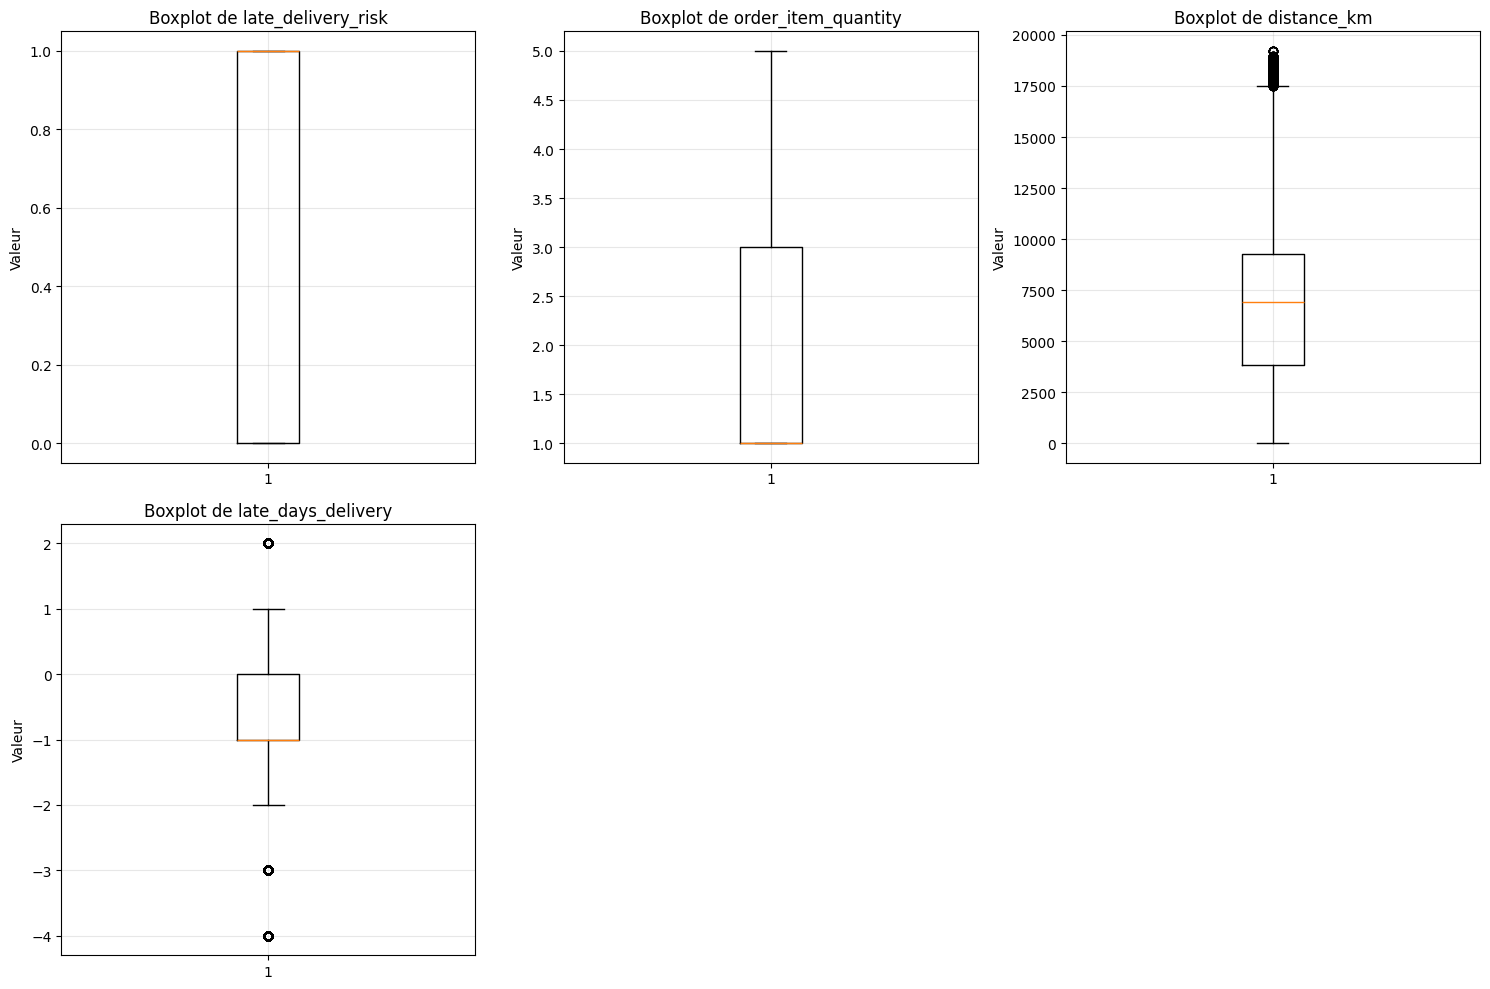

In [105]:
import matplotlib.pyplot as plt
numeric_cols = ["late_delivery_risk","order_item_quantity","distance_km","late_days_delivery"]

pdData = df_cleaned.toPandas()

n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if len(numeric_cols) > 1 else [axes]

for idx, col_name in enumerate(numeric_cols):
    axes[idx].boxplot(pdData[col_name].dropna())
    axes[idx].set_title(f'Boxplot de {col_name}')
    axes[idx].set_ylabel('Valeur')
    axes[idx].grid(True, alpha=0.3)

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [106]:
df_cleaned.select("order_item_quantity").distinct().count()


5

Text(0.5, 1.0, 'order_item_quantity')

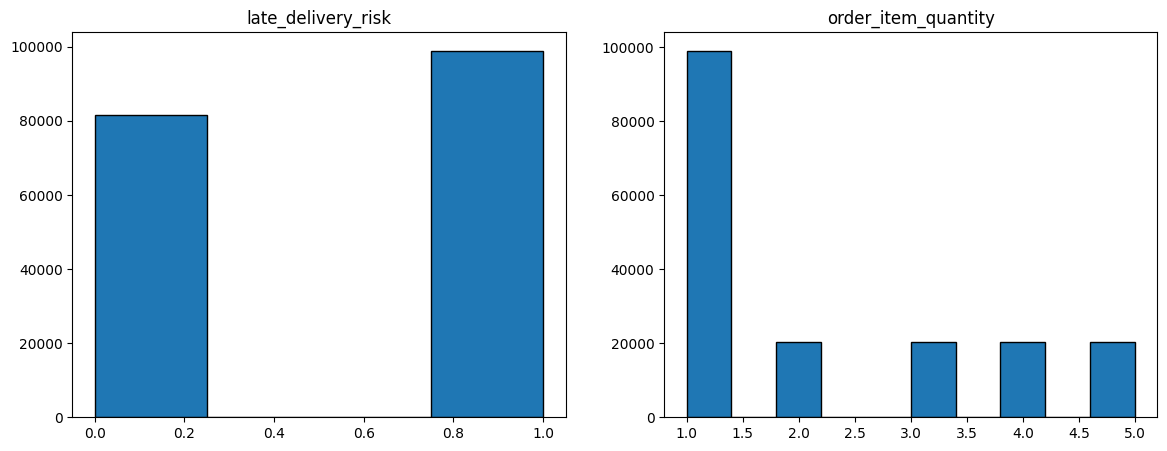

In [107]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(pdData["late_delivery_risk"],bins=4,edgecolor="black")
axes[0].set_title("late_delivery_risk")
axes[1].hist(pdData["order_item_quantity"],bins=10,edgecolor="black")
axes[1].set_title("order_item_quantity")

In [108]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

bor_data = pdData.select_dtypes(include=["number"]) 
bor_data = bor_data.dropna()

X = bor_data.drop('late_delivery_risk', axis=1).values
y = bor_data['late_delivery_risk'].values

rf = RandomForestClassifier(n_estimators=100, random_state=42)

boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

boruta_selector.fit(X, y)

selected_features_mask = boruta_selector.support_

selected_feature_names = bor_data.drop('late_delivery_risk', axis=1).columns[selected_features_mask]

print("Selected features by Boruta:")
print(selected_feature_names)

df_selected = bor_data[selected_feature_names]


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	1
Selected features by Boruta:
Index(['scheduled_days_for_shipping', 'distance_km', 'late_days_delivery'], dtype='object')


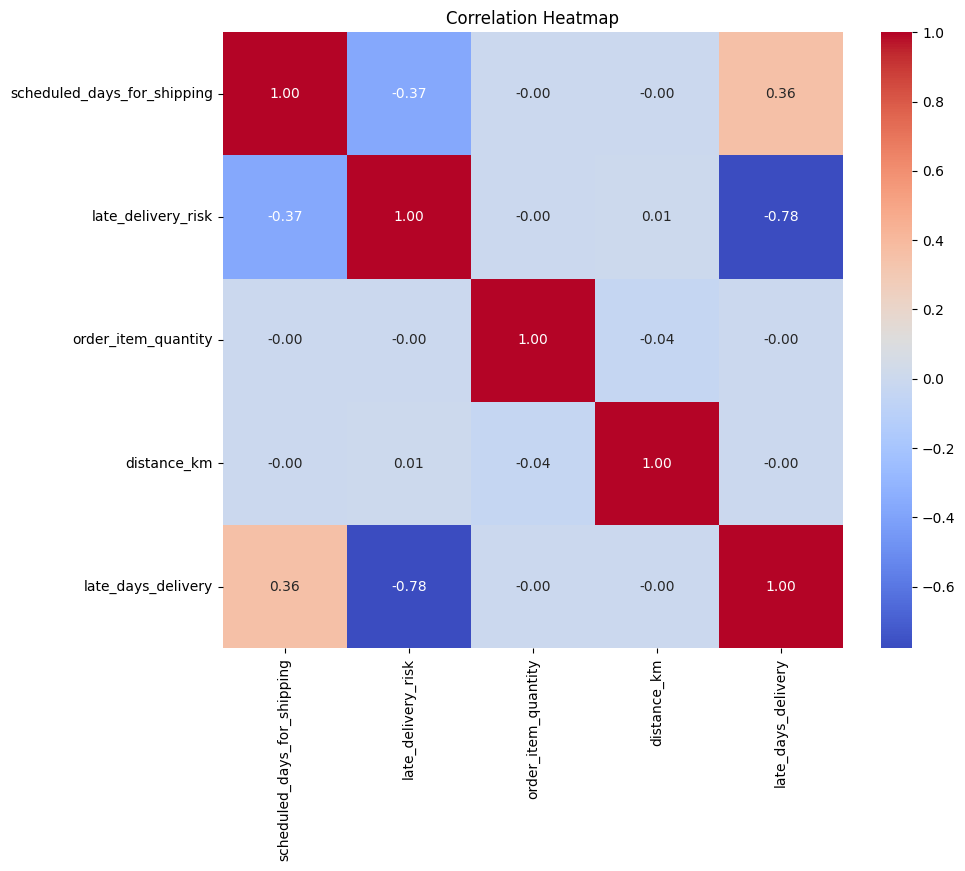

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = pdData.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [110]:
# df_cleaned.groupBy("category_name","late_delivery_risk").count().show()

# show = df_cleaned.filter((df_cleaned.category_name == "Women's Apparel") & (df_cleaned.late_delivery_risk == 0))

# show.show()

df_cleaned.show()

+---------------------------+------------------+--------------+----------------+-------------------+------------+--------------+------------------+------------------+
|scheduled_days_for_shipping|late_delivery_risk| category_name|customer_segment|order_item_quantity|product_name| shipping_mode|       distance_km|late_days_delivery|
+---------------------------+------------------+--------------+----------------+-------------------+------------+--------------+------------------+------------------+
|                          4|                 0|Sporting Goods|        Consumer|                  1|Smart watch |Standard Class|18524.387067726868|                 1|
|                          4|                 1|Sporting Goods|        Consumer|                  1|Smart watch |Standard Class| 13260.42013839824|                -1|
|                          4|                 0|Sporting Goods|        Consumer|                  1|Smart watch |Standard Class|12581.957379900818|                 0

In [111]:
# df_cleaned.filter((df_cleaned.customer_segment == "Consumer") & (df_cleaned.late_delivery_risk == 1)).count()
from pyspark.sql.functions import avg,max

df_cleaned.groupBy("late_delivery_risk","category_name").agg(avg("late_days_delivery"),max("order_item_quantity")).show()

+------------------+-------------------+-----------------------+------------------------+
|late_delivery_risk|      category_name|avg(late_days_delivery)|max(order_item_quantity)|
+------------------+-------------------+-----------------------+------------------------+
|                 1|      Shop By Sport|    -1.6285902938263452|                       5|
|                 0|     Men's Footwear|     0.7063703703703703|                       1|
|                 0|             Garden|      0.822429906542056|                       1|
|                 1|Baseball & Softball|     -1.679083094555874|                       5|
|                 1|         Golf Balls|    -1.6347826086956523|                       5|
|                 0|    Women's Apparel|     0.7047808348153572|                       5|
|                 0|     Men's Clothing|     0.7263157894736842|                       1|
|                 0|    As Seen on  TV!|     0.8620689655172413|                       5|
|         

# Feature Analysis for Late Delivery Risk Prediction

In [112]:
categorical_cols = [name for name, dtype in df_cleaned.dtypes if dtype == 'string']

for col_name in categorical_cols:
    print(f"\n{col_name.upper()}")
    print("-"*80)
    
    risk_by_category = df_cleaned.groupBy(col_name, "late_delivery_risk").count().orderBy(col_name, "late_delivery_risk")
    
    print(f"Unique values: {df_cleaned.select(col_name).distinct().count()}")
    print(f"\nTop 10 categories with late delivery distribution:")
    
    from pyspark.sql.window import Window
    from pyspark.sql.functions import sum as _sum
    
    window_spec = Window.partitionBy(col_name)
    
    risk_analysis = risk_by_category.withColumn("total", _sum("count").over(window_spec))
    risk_analysis = risk_analysis.filter(col("late_delivery_risk") == 1)
    risk_analysis = risk_analysis.withColumn("risk_rate", (col("count") / col("total") * 100))
    risk_analysis = risk_analysis.select(col_name, "count", "total", "risk_rate").orderBy(col("risk_rate").desc())
    
    risk_analysis.show(10, truncate=False)




CATEGORY_NAME
--------------------------------------------------------------------------------
Unique values: 50

Top 10 categories with late delivery distribution:
+-------------------+-----+-----+------------------+
|category_name      |count|total|risk_rate         |
+-------------------+-----+-----+------------------+
|Golf Bags & Carts  |42   |61   |68.85245901639344 |
|Lacrosse           |206  |343  |60.05830903790087 |
|Pet Supplies       |290  |492  |58.94308943089431 |
|Cameras            |344  |592  |58.108108108108105|
|Strength Training  |64   |111  |57.65765765765766 |
|As Seen on  TV!    |39   |68   |57.35294117647059 |
|Music              |248  |434  |57.14285714285714 |
|Accessories        |1014 |1780 |56.96629213483146 |
|Fitness Accessories|176  |309  |56.957928802588995|
|Books              |229  |405  |56.54320987654321 |
+-------------------+-----+-----+------------------+
only showing top 10 rows

CUSTOMER_SEGMENT
-------------------------------------------------

# Encoding Categorical Variables

This section encodes categorical features using:
- **StringIndexer**: Converts string categories to numerical indices
- **OneHotEncoder**: Creates binary columns for each category (prevents ordinal assumption)

In [113]:
# encoding cat values

categorical_cols = [name for name, dtype in df_cleaned.dtypes if dtype == 'string']

print(f"\nFound {len(categorical_cols)} categorical features:")
print("-"*80)

for idx, col in enumerate(categorical_cols, 1):
    distinct_count = df_cleaned.select(col).distinct().count()
    print(f"  {idx}. {col:<30}")



Found 4 categorical features:
--------------------------------------------------------------------------------
  1. category_name                 
  2. customer_segment              
  3. product_name                  
  4. shipping_mode                 


In [114]:
# StringIndexer

from pyspark.ml.feature import StringIndexer

df_encoded = df_cleaned


indexed_cols = []

for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep')
    df_encoded = indexer.fit(df_encoded).transform(df_encoded)
    indexed_cols.append(f"{col}_indexed")
    
    distinct_count = df_encoded.select(col).distinct().count()
    print(f"✓ {col:<30} → {col}_indexed (Categories: {distinct_count})")



✓ category_name                  → category_name_indexed (Categories: 50)
✓ customer_segment               → customer_segment_indexed (Categories: 3)
✓ product_name                   → product_name_indexed (Categories: 118)
✓ shipping_mode                  → shipping_mode_indexed (Categories: 4)


In [115]:
# OneHotEncoder

from pyspark.ml.feature import OneHotEncoder

onehot_cols = []

for col in categorical_cols:
    input_col = f"{col}_indexed"
    output_col = f"{col}_onehot"
    
    encoder = OneHotEncoder(inputCol=input_col, outputCol=output_col, dropLast=True)
    df_encoded = encoder.fit(df_encoded).transform(df_encoded)
    onehot_cols.append(output_col)
    
    print(f"✓ {input_col:<35} → {output_col}")

print("\n" + "="*80)
print(f"✓ Created {len(onehot_cols)} one-hot encoded vector columns")
print("="*80)

print("\nSample of encoded data (showing first 3 rows):")
print("-"*80)
df_encoded.select(categorical_cols + indexed_cols + onehot_cols).show(3, truncate=False)

✓ category_name_indexed               → category_name_onehot
✓ customer_segment_indexed            → customer_segment_onehot
✓ product_name_indexed                → product_name_onehot
✓ shipping_mode_indexed               → shipping_mode_onehot

✓ Created 4 one-hot encoded vector columns

Sample of encoded data (showing first 3 rows):
--------------------------------------------------------------------------------
+--------------+----------------+------------+--------------+---------------------+------------------------+--------------------+---------------------+--------------------+-----------------------+-------------------+--------------------+
|category_name |customer_segment|product_name|shipping_mode |category_name_indexed|customer_segment_indexed|product_name_indexed|shipping_mode_indexed|category_name_onehot|customer_segment_onehot|product_name_onehot|shipping_mode_onehot|
+--------------+----------------+------------+--------------+---------------------+----------------------

In [116]:
# Clean Dataset with Encoded Features

numerical_cols = [name for name, dtype in df_encoded.dtypes if dtype in ['int', 'bigint', 'double', 'float'] and name != 'late_delivery_risk']

numerical_cols = [col for col in numerical_cols if not col.endswith('_indexed')]

print("\nDataset composition:")
print("-"*80)
print(f"  Numerical features:     {len(numerical_cols)}")
print(f"  One-hot encoded:        {len(onehot_cols)}")
print(f"  Target variable:        1 (late_delivery_risk)")
print(f"  Original categoricals:  {len(categorical_cols)} (will be dropped)")
print(f"  Indexed features:       {len(indexed_cols)} (will be dropped)")

final_cols = numerical_cols + onehot_cols + ['late_delivery_risk']

print(f"\n✓ Final dataset will have {len(final_cols)} columns")
print("-"*80)

df_final_encoded = df_encoded.select(final_cols)

print("\n✓ Dataset structure:")
print("-"*80)
df_final_encoded.printSchema()

print("\n" + "="*80)
print(f"✓ Final encoded dataset ready: df_final_encoded")
print(f"✓ Rows: {df_final_encoded.count():,}")
print(f"✓ Columns: {len(df_final_encoded.columns)}")
print("="*80)


Dataset composition:
--------------------------------------------------------------------------------
  Numerical features:     4
  One-hot encoded:        4
  Target variable:        1 (late_delivery_risk)
  Original categoricals:  4 (will be dropped)
  Indexed features:       4 (will be dropped)

✓ Final dataset will have 9 columns
--------------------------------------------------------------------------------

✓ Dataset structure:
--------------------------------------------------------------------------------
root
 |-- scheduled_days_for_shipping: integer (nullable = true)
 |-- order_item_quantity: integer (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- late_days_delivery: integer (nullable = true)
 |-- category_name_onehot: vector (nullable = true)
 |-- customer_segment_onehot: vector (nullable = true)
 |-- product_name_onehot: vector (nullable = true)
 |-- shipping_mode_onehot: vector (nullable = true)
 |-- late_delivery_risk: integer (nullable = true)


✓ Fin

In [117]:
df_final_encoded.columns

df_final_encoded = df_final_encoded.drop("shipping_mode_onehot","customer_segment_onehot","order_item_quantity","category_name_onehot","distance_km","product_name_onehot","late_days_delivery")

In [118]:
df_final_encoded.columns

['scheduled_days_for_shipping', 'late_delivery_risk']

In [119]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [col for col in df_final_encoded.columns if col != 'late_delivery_risk']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

df_model_ready = assembler.transform(df_final_encoded)

df_model_ready = df_model_ready.select('features', 'late_delivery_risk')

df_model_ready.printSchema()

df_model_ready.show(5, truncate=False)


root
 |-- features: vector (nullable = true)
 |-- late_delivery_risk: integer (nullable = true)

+--------+------------------+
|features|late_delivery_risk|
+--------+------------------+
|[4.0]   |0                 |
|[4.0]   |1                 |
|[4.0]   |0                 |
|[4.0]   |0                 |
|[4.0]   |0                 |
+--------+------------------+
only showing top 5 rows


In [120]:
df_cleaned = df_cleaned.drop("late_days_delivery")

In [121]:
df_cleaned.columns

['scheduled_days_for_shipping',
 'late_delivery_risk',
 'category_name',
 'customer_segment',
 'order_item_quantity',
 'product_name',
 'shipping_mode',
 'distance_km']

In [122]:
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.sql.functions import col


numerical_features = [name for name, dtype in df_cleaned.dtypes 
                      if dtype in ['int', 'bigint', 'double', 'float'] and name != 'late_delivery_risk']

print(f"Found {len(numerical_features)} numerical features: {numerical_features}")

numerical_assembler = VectorAssembler(
    inputCols=numerical_features,
    outputCol='numerical_features_vector'
)

df_with_num_vector = numerical_assembler.transform(df_cleaned)
print(f"✓ Assembled {len(numerical_features)} numerical features")

scaler = StandardScaler(
    inputCol='numerical_features_vector',
    outputCol='scaled_numerical_features',
    withMean=True,  
    withStd=True    
)

scaler_model = scaler.fit(df_with_num_vector)
df_with_scaled_vector = scaler_model.transform(df_with_num_vector)

categorical_cols = [name for name, dtype in df_cleaned.dtypes if dtype == 'string']

df_encoded = df_with_scaled_vector
indexed_cols = []
onehot_cols = []

for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_indexed", handleInvalid='keep')
    df_encoded = indexer.fit(df_encoded).transform(df_encoded)
    indexed_cols.append(f"{col_name}_indexed")


for col_name in categorical_cols:
    input_col = f"{col_name}_indexed"
    output_col = f"{col_name}_onehot"
    encoder = OneHotEncoder(inputCol=input_col, outputCol=output_col, dropLast=True)
    df_encoded = encoder.fit(df_encoded).transform(df_encoded)
    onehot_cols.append(output_col)

feature_cols = ['scaled_numerical_features'] + onehot_cols

final_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_model_ready_scaled = final_assembler.transform(df_encoded)

df_model_ready_scaled = df_model_ready_scaled.select('features', 'late_delivery_risk')

Found 3 numerical features: ['scheduled_days_for_shipping', 'order_item_quantity', 'distance_km']
✓ Assembled 3 numerical features


# Class Imbalance Check

In [123]:
import builtins
class_counts = df_model_ready_scaled.groupBy('late_delivery_risk').count().orderBy('late_delivery_risk')
class_data = class_counts.collect()

total = sum([row['count'] for row in class_data])
on_time = class_data[0]['count']
delayed = class_data[1]['count']

print("\n📊 Target Variable Distribution:")
print("-"*80)
print(f"  Class 0 (On Time):  {on_time:,} ({on_time/total*100:.2f}%)")
print(f"  Class 1 (Delayed):  {delayed:,} ({delayed/total*100:.2f}%)")
print(f"  Total samples:      {total:,}")


imbalance_ratio = builtins.max(on_time, delayed) / builtins.min(on_time, delayed)
print(f"\n⚖️ Imbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio < 1.5:
    print("  ✓ Classes are BALANCED - No action needed")
elif imbalance_ratio < 3:
    print("  ⚠ Slight imbalance - Consider class weights")
else:
    print("  ❌ IMBALANCED - Use SMOTE, class weights, or stratified sampling")

print("="*80)


📊 Target Variable Distribution:
--------------------------------------------------------------------------------
  Class 0 (On Time):  81,542 (45.17%)
  Class 1 (Delayed):  98,977 (54.83%)
  Total samples:      180,519

⚖️ Imbalance Ratio: 1.21:1
  ✓ Classes are BALANCED - No action needed


# Train/Test Split & Model Training

In [124]:
print("="*80)
print("TRAIN/TEST SPLIT")
print("="*80)

train_data, test_data = df_model_ready_scaled.randomSplit([0.8, 0.2], seed=42)

print(f"✓ Training set: {train_data.count():,} samples ({train_data.count()/df_model_ready_scaled.count()*100:.1f}%)")
print(f"✓ Test set:     {test_data.count():,} samples ({test_data.count()/df_model_ready_scaled.count()*100:.1f}%)")
print("="*80)

TRAIN/TEST SPLIT
✓ Training set: 144,625 samples (80.1%)
✓ Test set:     35,894 samples (19.9%)


In [125]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='late_delivery_risk',
    numTrees=100,
    maxDepth=10,
    seed=42
)

model = rf.fit(train_data)



In [126]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

predictions = model.transform(test_data)

acc_evaluator = MulticlassClassificationEvaluator(labelCol='late_delivery_risk', metricName='accuracy')
accuracy = acc_evaluator.evaluate(predictions)

auc_evaluator = BinaryClassificationEvaluator(labelCol='late_delivery_risk', metricName='areaUnderROC')
auc = auc_evaluator.evaluate(predictions)

precision_evaluator = MulticlassClassificationEvaluator(labelCol='late_delivery_risk', metricName='weightedPrecision')
recall_evaluator = MulticlassClassificationEvaluator(labelCol='late_delivery_risk', metricName='weightedRecall')
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

print(f"\nModel Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  AUC-ROC:   {auc:.4f}")



Model Performance:
  Accuracy:  0.6939
  Precision: 0.7202
  Recall:    0.6939
  AUC-ROC:   0.7332


# Check for Overfitting

In [127]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

train_predictions = model.transform(train_data)
train_accuracy = MulticlassClassificationEvaluator(labelCol='late_delivery_risk', metricName='accuracy').evaluate(train_predictions)
train_auc = BinaryClassificationEvaluator(labelCol='late_delivery_risk', metricName='areaUnderROC').evaluate(train_predictions)

test_predictions = model.transform(test_data)
test_accuracy = MulticlassClassificationEvaluator(labelCol='late_delivery_risk', metricName='accuracy').evaluate(test_predictions)
test_auc = BinaryClassificationEvaluator(labelCol='late_delivery_risk', metricName='areaUnderROC').evaluate(test_predictions)

print("\n Performance Comparison:")
print("-"*80)
print(f"{'Metric':<15} {'Training':<15} {'Test':<15} {'Difference':<15}")
print("-"*80)
print(f"{'Accuracy':<15} {train_accuracy:<15.4f} {test_accuracy:<15.4f} {(train_accuracy-test_accuracy):<15.4f}")
print(f"{'AUC-ROC':<15} {train_auc:<15.4f} {test_auc:<15.4f} {(train_auc-test_auc):<15.4f}")

gap = train_accuracy - test_accuracy



 Performance Comparison:
--------------------------------------------------------------------------------
Metric          Training        Test            Difference     
--------------------------------------------------------------------------------
Accuracy        0.6916          0.6939          -0.0023        
AUC-ROC         0.7366          0.7332          0.0034         
